<a href="https://colab.research.google.com/github/HumzaW245/iCAD-Dental/blob/main/iCAD_Dental_Coding_Test_Colab_BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading data using kaggle API

Read comment by 'Nikhil Ojha' for simple instructions on how to do download dataset (https://www.kaggle.com/discussions/general/74235)

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload() #Upload kaggle.json (it contains API key to access kaggle datasets)



from IPython.display import clear_output
clear_output() #To clear output printed since previous lines will show kaggle API key information


# IN NEW ENVIRONMENTS, Need to go in colab /content/ folder and create new folder called 'kaggle' first
# then can upload kaggle.json and run code

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# To download dataset, go to dataset ->https://www.kaggle.com/datasets/salviohexia/isic-2019-skin-lesion-images-for-classification/discussion
# Then click 3 dots menu -> 'Copy API Command'
# since in google colab, need to do ! first -> ! <pastedAPIcommandHere>

! kaggle datasets download -d salviohexia/isic-2019-skin-lesion-images-for-classification

100% 9.09G/9.10G [05:24<00:00, 23.2MB/s]
100% 9.10G/9.10G [05:24<00:00, 30.1MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('isic-2019-skin-lesion-images-for-classification.zip', 'r')
zip_ref.extractall('/content/ISIC2019')
zip_ref.close()

In [7]:
# ctrl-f 'In [13]' if want details of making a complete dataset using the metadata too -> https://www.kaggle.com/code/shonenkov/merge-external-data/notebook

import pandas as pd

# Specify the path to the CSV files
metadata_csv_file_path = '/content/ISIC2019/ISIC_2019_Training_Metadata.csv'
data_csv_file_path = '/content/ISIC2019/ISIC_2019_Training_GroundTruth.csv'



# Load the metadata and main data from the CSV file
metadata_df = pd.read_csv(metadata_csv_file_path)
main_df = pd.read_csv(data_csv_file_path)


#Getting class name and index column (index is used to make predictions more easily)

#Original Class is different since in binary classificaion we make assumption SCC and VASC are one category and the rest are tumours
main_df['Original_Class'] = main_df.apply(lambda row: main_df.columns[(row == 1)].tolist()[0], axis=1)


def reduce_data_50pct(df):

  class_counts = df['Original_Class'].value_counts()
  #print(class_counts)
  target_size = class_counts // 2  # Half of the original size for each class
  #print(target_size)
  reduced_df = pd.DataFrame(columns=df.columns)

  for class_label, size in target_size.items():
      class_subset = df[df['Original_Class'] == class_label].head(size)
      reduced_df = reduced_df.append(class_subset)
  return reduced_df

main_df = reduce_data_50pct(main_df)
#print(f"NEW VALUE COUNTS: {main_df['Original_Class'].value_counts()}")

def mapBinaryClassName(className):
  if className in ['VASC', 'SCC']:
    return 'not_tumour'
  else:
    return 'tumour'

main_df['Class'] = main_df['Original_Class'].apply(lambda original_class: mapBinaryClassName(original_class))

#Binary classification we assume: SCC and VASC are one category and the rest are tumours
class_idx_map = {'tumour': 1, 'not_tumour': 0}
main_df['Class_Index'] = main_df['Class'].apply(lambda class_name: class_idx_map[class_name])


main_df = main_df[['image', 'Original_Class', 'Class', 'Class_Index']]
#print(main_df['Class'].value_counts())
print(main_df.head(-5))

              image Original_Class   Class  Class_Index
0      ISIC_0000000             NV  tumour            1
1      ISIC_0000001             NV  tumour            1
3      ISIC_0000003             NV  tumour            1
5      ISIC_0000006             NV  tumour            1
6      ISIC_0000007             NV  tumour            1
...             ...            ...     ...          ...
12407  ISIC_0033810             DF  tumour            1
12444  ISIC_0033847             DF  tumour            1
12457  ISIC_0033860             DF  tumour            1
12488  ISIC_0033891             DF  tumour            1
12732  ISIC_0034135             DF  tumour            1

[12658 rows x 4 columns]


<ipython-input-7-94f6d91b38c9>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(class_subset)
<ipython-input-7-94f6d91b38c9>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(class_subset)
<ipython-input-7-94f6d91b38c9>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(class_subset)
<ipython-input-7-94f6d91b38c9>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_df = reduced_df.append(class_subset)
<ipython-input-7-94f6d91b38c9>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version.

In [8]:
dataset_dir = '/content/ISIC2019/'

import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, dataframe, transform=None):
        self.root_dir = root_dir
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx]['Class_Index']
        class_name = self.dataframe.iloc[idx]['Original_Class']#Use original_class here since lookup in folders needs to be through original class names since no folder named e.g. 'tumour'
        #Get label index to tensor
        label = torch.tensor(label)

        #Get image
        img_id = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, class_name + '/' + img_id + '.jpg')
        image = Image.open(img_path).convert('RGB')

        #Apply transformations to image
        if self.transform:
            image = self.transform(image)

        return image, label



# DataLoaders and Transformations

In [9]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Split the data frame into training and test sets
train_df, test_df = train_test_split(main_df, test_size=0.2, random_state=42)


# Transformations to use for preprocessing (Arbitrarily chose these to have standardized data)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a common size
    transforms.ToTensor(),  # Convert PIL Image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

train_data = CustomDataset(dataset_dir, train_df, transform = data_transforms)
test_data = CustomDataset(dataset_dir, test_df, transform = data_transforms)

# Train and Test functions for how training will be done

In [10]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

def train(model, device, train_loader, optimizer, epoch, display=True):
    #Set model to training mode ----------------------------------CARE WHEN NORMALIZATION, DIFFERENT FOR TRAIN/TEST---------------------
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        #Data to device
        data, target = data.to(device), target.to(device)

        #Reset grad for next batch
        optimizer.zero_grad()
        output = model(data)

        #Loss
        loss = F.cross_entropy(output, target)

        #Backprop
        loss.backward()

        #Optimization step (Parameter Update)
        optimizer.step()


    #Log results of each epoch. CARE: Epoch will be an integer passed so the parameter is ONLY for tracking here. train(...) needs to be called in a loop based on how many epochs are to be trained (each epoch's index passed as epoch)
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    #Set model to test mode ----------------------------------CARE WHEN NORMALIZATION, DIFFERENT FOR TRAIN/TEST---------------------
    model.eval()

    true_labels = []  # To collect true labels
    predicted_labels = []  # To collect predicted labels

    test_loss = 0
    correct = 0

    #no_grad() will not hold grad, which is fine since we do not want to calculate gradient as we are only interested in checking the prediction from the forward pass.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            #Test Loss
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss

            #Predicted class
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            #Number of correct predictions in the batch to update overall total of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Collect true and predicted labels
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(pred.cpu().numpy())

    #Average test loss over all dataset
    test_loss /= len(test_loader.dataset)

    #Log results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print('Confusion Matrix:')
    print(conf_matrix)

    # Calculate specificity (modify based on your specific class labels)
    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    print(f'Specificity: {specificity:.2f}')

    return accuracy, true_labels, predicted_labels



# Define the Network

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models

class Net(torch.nn.Module):
    '''
    Constructor. Define all layers (These were chosen through trying different variations by starting with 2-3 convolution layers and adding batchNorm and pooling between them as needed, with different parameters)
    '''
    def __init__(self, finetune_backbones):
        super(Net, self).__init__()
        self.model =  models.resnet50(pretrained=True)

        # FT backbone (before output layers. freeze/unfreeze)
        self.finetune_backbones = finetune_backbones
        for i, param in enumerate(self.model.parameters()):
          param.requires_grad = self.finetune_backbones


        #New output head for the target task
        in_features = self.model.fc.in_features #The fc layer of resenet50 is Linear(in_features=2048, out_features=1000, bias=True) so storing the 2048 and replacing this to map from 2048 to numClasses for target task ====can see the fc layer like this: backbone = models.resnet50(pretrained=True) => print(backbone.fc)
        targetTaskOutFeatures = 2 # num of classes in target task
        classifier = nn.Linear(in_features, targetTaskOutFeatures, bias=True)  # Create a new classifier
        classifier.weight.requires_grad = True
        classifier.bias.requires_grad = True
        self.model.fc = classifier  # Replace the classifier layer

        # self.layers = nn.ModuleList()

        # # 3 Channels in (RGB at the start is what image channels are) and 16 channels out (arbitrarily chose 16)
        # self.layers+=[nn.Conv2d(3, 16,  kernel_size=3) ,
        #               nn.ReLU(inplace=True)]

        # # Batch norm layer to normalize the tensor produced from convolution so covariances are not too high and this can help avoid issues like oscillating loss
        # self.layers+=[nn.BatchNorm2d(16)]

        # # Pooling to reduce number of params to learn so training time is improved by reducing dimension (e.g. image size) as it passes through the Net
        # # basically as if multiple pixels would share the same parameter so 1 gradient is calculated between multiple pixels to allow training without needing higher number of computations (less gradients to calculate)
        # self.layers+=[nn.MaxPool2d(kernel_size= 2, stride=2, padding= 0)]

        # self.layers+=[nn.Conv2d(16, 32,  kernel_size=3),
        #               nn.ReLU(inplace=True)]

        # self.layers+=[nn.MaxPool2d(kernel_size= 2, stride=2, padding= 0)]

        # self.layers+=[nn.Conv2d(32, 32,  kernel_size=3),
        #               nn.ReLU(inplace=True)]

        # self.layers+=[nn.MaxPool2d(kernel_size= 2, stride=2, padding= 0)]


        # '''
        # Linear layers after flattening
        # # '''
        # self.fc1 = nn.Linear(32*26*26, 64) #NEED TO MODIFY first argument to output of previous layers' size product of each observation. THIS BASED ON LAST INPUT SIZE (Changes as we do convolutions, pooling, etc)
        # self.layer_norm1 = nn.LayerNorm(64)
        # self.fc2 = nn.Linear(64, 30)
        # self.layer_norm2 = nn.LayerNorm(30)
        # self.fc3 = nn.Linear(30, 9) # Linear layer from X neurons to Y where y is number of classes being predicted
    '''
    Forward Pass
    '''
    def forward(self, x):

        x = self.model(x)
        return x
        # for i in range(len(self.layers)):
        #   #print(f'Input size before layer: {self.layers[i]} --- size: {x.shape}')
        #   x = self.layers[i](x)

        #print(f'Input size before flattening convolution layers result -> {x.shape}')
        # outChannelsHeightWidthproduct = x.shape[1]*x.shape[2]*x.shape[3]
        # x = x.view(-1, outChannelsHeightWidthproduct)


        # x = nn.functional.relu(self.fc1(x))


        # x = self.layer_norm1(x)
        # x = nn.functional.relu(self.fc2(x))
        # x = self.layer_norm2(x)
        # x = self.fc3(x)
        #print(f'Final input size -> {x.shape}')
        #return x


    '''
    Turn finetuning of the backbone layers on or off.
    '''
    def FTBackbone(backbone, boolVal):
      for i, param in enumerate(backbone.parameters()):
        param.requires_grad = boolVal



# Execute training and testing

In [12]:
def evaluate(train_data, val_data, epochs, b_size, lr, momentum, weight_decay, optimizer_name, finetune_backbones):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    '''
    Send to dataloader
    '''
    #Make use of dataloader so we can easily work with it later on.
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=b_size,
                                              shuffle=True,
                                              drop_last = True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=b_size,
                                            shuffle=False,
                                            drop_last = True)


    '''
    Initialize model, send to device and set optimizer
    '''
    model = Net(finetune_backbones).to(device)

    #Optimizer
    if optimizer_name == "SGD":
      print(f'USING OPTIMIZER -------- SGD')
      optimizer = torch.optim.SGD(model.parameters(),lr=lr, momentum= momentum, weight_decay= weight_decay)
    else:
      print(f'USING OPTIMIZER -------- ADAM')
      optimizer = torch.optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)



    '''
    Train model for certain epochs
    '''
    for epoch in range(epochs):
      train(model, device, train_loader, optimizer, epoch, display= True)# epoch%5==0)

    '''
    Test model and results (will run for each seed and store result so all seed accuracies can be aggregated)
    '''
    accuracy, true_labels, predicted_labels = test(model, device, val_loader)

    #Average accuracies over all random state seeds
    print('='*30)
    print(f'Hyperparameters used were: \n epochs, b_size, lr, momentum, weight_decay\n {epochs}, {b_size}, {lr}, {momentum}, {weight_decay}')

    return model


In [13]:
epochs = 2
b_size = 128
lr = 0.0001
momentum = 0
weight_decay = 0.0005
optimizer_name = 'SGD'
finetune_backbones = False

model = evaluate(train_data, test_data, epochs, b_size, lr, momentum, weight_decay, optimizer_name, finetune_backbones)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]


USING OPTIMIZER -------- SGD
Train Epoch: 0 [9984/10130 (99%)]	Loss: 0.203481
Train Epoch: 1 [9984/10130 (99%)]	Loss: 0.228192


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1838, Accuracy: 2343/2533 (92.50%)

Confusion Matrix:
[[   0   89]
 [   0 2343]]
Specificity: 0.00
Hyperparameters used were: 
 epochs, b_size, lr, momentum, weight_decay
 2, 128, 0.0001, 0, 0.0005


# Visualize Feature Map for one of the CNN layers

In [35]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

'''
Visualization of a feature map (Using first layer for this exercise)
'''
def visualize_feature_map(model, img_path, device):
  layer_name = 'conv1'
  layer = getattr(model, layer_name)

  # Create a function to register forward hooks to capture feature maps
  activation = {}

  def get_activation(name):
      def hook(model, input, output):
          activation[name] = output
      return hook

  # Register the forward hook to the chosen layer
  hook = layer.register_forward_hook(get_activation(layer_name))

  # Load and preprocess an image for visualization
  img = Image.open(img_path)
  preprocess = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  img_tensor = preprocess(img)
  img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
  img_tensor = img_tensor.to(device)

  # Set the model in evaluation mode and perform a forward pass
  model.eval()
  with torch.no_grad():
      output = model(img_tensor)

  # Retrieve the feature maps from the dictionary
  feature_map = activation[layer_name].squeeze(0)

  # Visualize the feature maps
  print(feature_map.size(0))
  for i in range(feature_map.size(0)):
      plt.subplot(8, 8, i + 1)  # You can adjust the layout based on the number of feature maps
      plt.imshow(feature_map[i].cpu(), cmap='binary_r')  # You can use other colormaps as well
      plt.axis('off')

  # Save the plot to a file
  plt.savefig('conv1_feature_maps.png')

  plt.show()


64


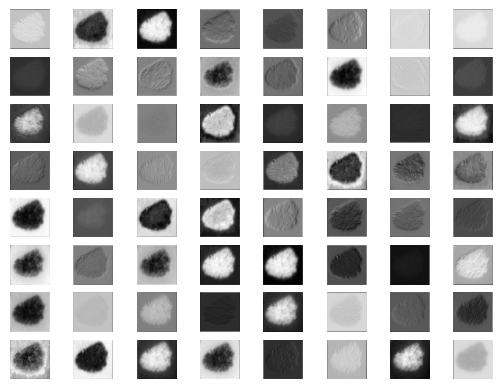

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:

class_name = 'NV'
img_id = 'ISIC_0000000'
img_path = os.path.join('/content/ISIC2019/', class_name + '/' + img_id + '.jpg')
visualize_feature_map(model.model, img_path, 'cuda')


#download the plot
files.download('conv1_feature_maps.png')

# SHAP to explain model's decisions

In [38]:
! pip install shap




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.8 MB/s eta 0:00:00


In [41]:
import shap


In [95]:
# python function to get model output; replace this function with your own model function. (reference: https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html)

device = 'cuda'

# Load and preprocess an image for visualization
img = Image.open(img_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
img_tensor = img_tensor.to(device)


def getModelOutput(img_tensor):
    return model(img_tensor)


val_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=b_size,
                                            shuffle=False,
                                            drop_last = True)

# Create an iterator from the data loader
data_iterator = iter(val_loader)
#print(test_data)
X, y = next(data_iterator)
X = X.permute(0, 2, 3, 1) #SHAP expects this shape so have to rearrange channels
X = X.cpu().numpy()
# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(224, 224)", X[0].shape)


# create an explainer with model and image masker
explainer_blur = shap.Explainer(getModelOutput, masker_blur)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer_blur(
    X[3:4], max_evals=5000, batch_size=32, outputs=shap.Explanation.argsort.flip[:4] #Show the top 4 features (:4) so produces 4 images
)

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:34, 34.30s/it]               


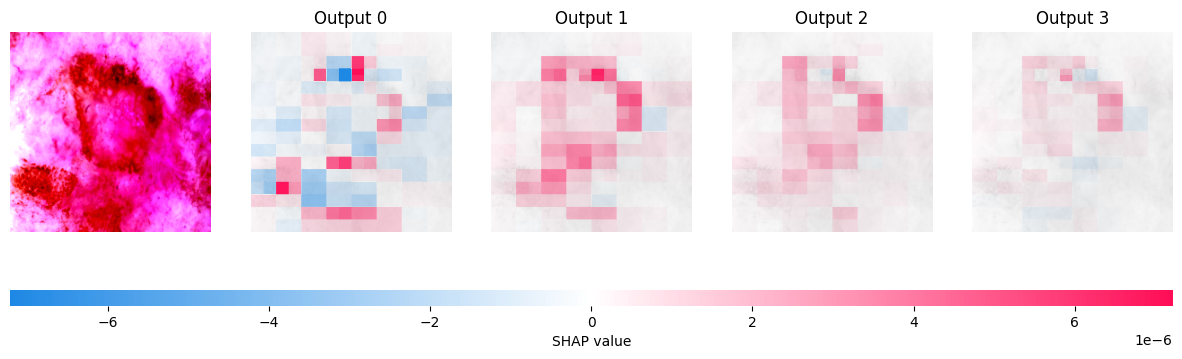

In [96]:
# output with shap values
shap.image_plot(shap_values)

In [99]:
plt.savefig('shap_top_features_explained.png')

#download the plot
files.download('shap_top_features_explained.png')

print("\nThe shap plot shows the top 4 features (or in this case, pixel arrangements) that impact the prediction accuracy of there being a tumour or not.\n\
      The blue pixels represent low SHAP values which suggest that the presence of these pixels lowers the predicitability for the model. The more intense the blue\n\
      (more negative SHAP value), means more significant influence and so those pixels make predictions worse compared to 'less blue' ones.\n\
      The red pixels represent positive shap values and these are what the model uses best to predict correctly the presence of tumours. Similarly, \n\
      the more red (more positive SHAP value) means the pixel is more important in making a correct prediction. ")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


The shap plot shows the top 4 features (or in this case, pixel arrangements) that impact the prediction accuracy of there being a tumour or not.
      The blue pixels represent low SHAP values which suggest that the presence of these pixels lowers the predicitability for the model. The more intense the blue
      (more negative SHAP value), means more significant influence and so those pixels make predictions worse compared to 'less blue' ones.
      The red pixels represent positive shap values and these are what the model uses best to predict correctly the presence of tumours. Similarly, 
      the more red (more positive SHAP value) means the pixel is more important in making a correct prediction. 


<Figure size 640x480 with 0 Axes>